In [1]:
# Import Depedency
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import seaborn as sns
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Folder menyimpan hasil training dan evaluasi
folder_path = f"run/"
os.makedirs(folder_path, exist_ok=True)

In [3]:
# List label
class_names = ['CLL', 'FL', 'MCL']

# Dimensi gambar
image_size = (260, 347)

In [4]:
# Menampilkan list label
print(class_names)


['CLL', 'FL', 'MCL']


In [5]:
X_train = np.load('/kaggle/input/lymphoma2/x_train.npy')
y_train = np.load('/kaggle/input/lymphoma2/y_train.npy')
X_valid = np.load('/kaggle/input/lymphoma2/x_valid.npy')
y_valid = np.load('/kaggle/input/lymphoma2/y_valid.npy')

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(4188, 260, 347, 3)
(4188,)
(898, 260, 347, 3)
(898,)


In [7]:
# Hyperparameter untuk CNN
learning_rate = 0.001
epochs = 100
batch_size = 8

In [8]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.optimizers import Adagrad
import tensorflow as tf

# Strategi distribusi untuk multiple GPUs
strategy = tf.distribute.MirroredStrategy()

# Membangun model di dalam strategi
with strategy.scope():
    # Deklarasi model 
    base_model = DenseNet169(
        weights='imagenet', 
        include_top=False, 
        input_shape=(image_size[0], image_size[1], 3),
    )

    num_layers_to_train = int(np.ceil(0.4 * len(base_model.layers)))

    for layer in base_model.layers[num_layers_to_train:] :
        layer.trainable = False

    # Base tuning
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Optimizer
    model.compile(optimizer=Adagrad(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Rangkuman model
    model.summary()

51877672/51877672 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 260, 347, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 266, 353, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 130, 174, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

In [9]:
# Callback (simpan model terbaik, menyimpan hasil training ke csv, dan early stop)
model_checkpoint = ModelCheckpoint(os.path.join(folder_path, f"best_model.h5"), monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger(os.path.join(folder_path, f"log.csv"), separator=',', append=False)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Hitung waktu training
start_time = time.time()

# Training
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[model_checkpoint, csv_logger],
    batch_size=batch_size,
)

# Hitung waktu training
end_time = time.time()

# Menampilkan lama proses training
print(f"Training Time : {end_time - start_time}")

Epoch 1/100
524/524 [==============================] - ETA: 0s - loss: 0.5883 - accuracy: 0.7717

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


524/524 [==============================] - 124s 148ms/step - loss: 0.5883 - accuracy: 0.7717 - val_loss: 0.3675 - val_accuracy: 0.8508
Epoch 2/100
524/524 [==============================] - 67s 127ms/step - loss: 0.1923 - accuracy: 0.9300 - val_loss: 0.0903 - val_accuracy: 0.9666
Epoch 3/100
524/524 [==============================] - 67s 127ms/step - loss: 0.1204 - accuracy: 0.9589 - val_loss: 0.0665 - val_accuracy: 0.9788
Epoch 4/100
524/524 [==============================] - 64s 123ms/step - loss: 0.0688 - accuracy: 0.9761 - val_loss: 0.0679 - val_accuracy: 0.9788
Epoch 5/100
524/524 [==============================] - 67s 128ms/step - loss: 0.0542 - accuracy: 0.9819 - val_loss: 0.0526 - val_accuracy: 0.9811
Epoch 6/100
524/524 [==============================] - 64s 123ms/step - loss: 0.0384 - accuracy: 0.9897 - val_loss: 0.0973 - val_accuracy: 0.9666
Epoch 7/100
524/524 [==============================] - 64s 123ms/step - loss: 0.0385 - accuracy: 0.9876 - val_loss: 0.0704 - val_accura

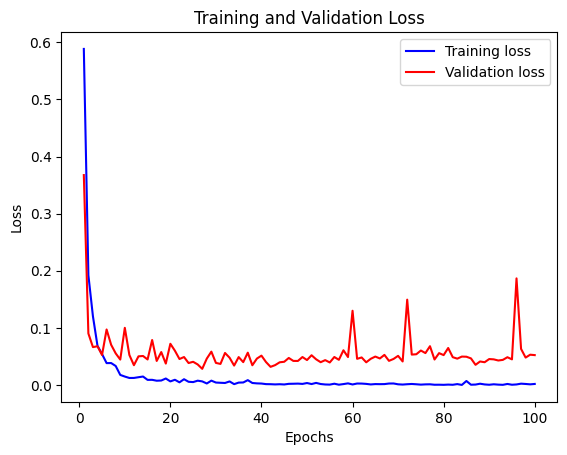

In [10]:
# Menampilkan grafik loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(folder_path, 'loss.png'))
plt.show()

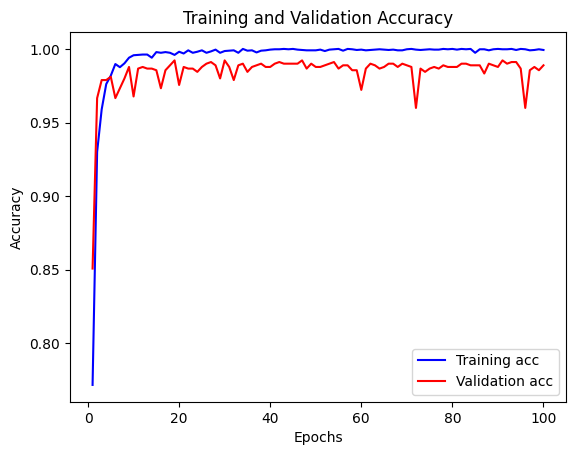

In [11]:
# Menampilkan grafik akurasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(folder_path, 'accuracy.png'))
plt.show()

In [12]:
del X_train
del y_train
del X_valid
del y_valid

In [13]:
X_test = np.load('/kaggle/input/lymphoma2/x_test.npy')
y_test = np.load('/kaggle/input/lymphoma2/y_test.npy')

In [14]:
# Menampilkan classification report
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)

classification_rep = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n", classification_rep)

with open(os.path.join(folder_path, 'classification_report.txt'), 'w') as file:
    file.write(classification_rep)

29/29 [==============================] - 9s 93ms/step
Classification Report:
               precision    recall  f1-score   support

         CLL     0.9962    0.9925    0.9944       267
          FL     0.9908    0.9939    0.9923       326
         MCL     0.9902    0.9902    0.9902       305

    accuracy                         0.9922       898
   macro avg     0.9924    0.9922    0.9923       898
weighted avg     0.9922    0.9922    0.9922       898



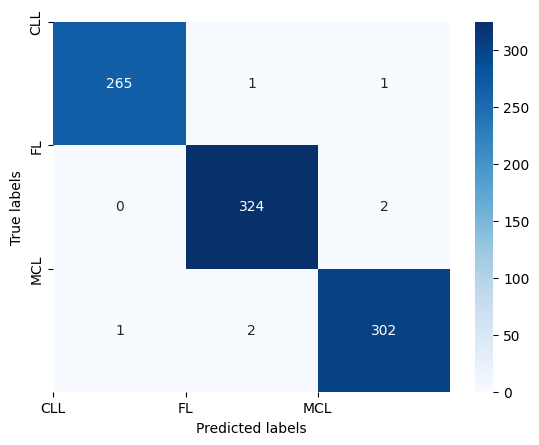

In [15]:
# Menampilkan confussion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(os.path.join(folder_path, 'confusion matrix.png'))
plt.show()